# Image Classification with Hugging Face Transformers and `Keras` 
### Image Classification Example using vanilla `Keras`, `Transformers`, `Datasets` and, Vision Transformer

# Introduction

Welcome to this end-to-end Image Classification example using Keras and Hugging Face Transformers. In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with `Tensorflow` & `Keras` to fine-tune a pre-trained vision transformer for image classification.

We are going to use the [EuroSAT](https://paperswithcode.com/dataset/eurosat) dataset for land use and land cover classification. The dataset is based on Sentinel-2 satellite images covering 13 spectral bands and consisting out of 10 classes within total 27,000 labeled and geo-referenced images.

More information for the dataset can be found at the [repository](https://github.com/phelber/eurosat).


We are going to use all of the great Features from the Hugging Face ecosystem like model versioning and experiment tracking as well as all the great features of Keras like Early Stopping and Tensorboard.

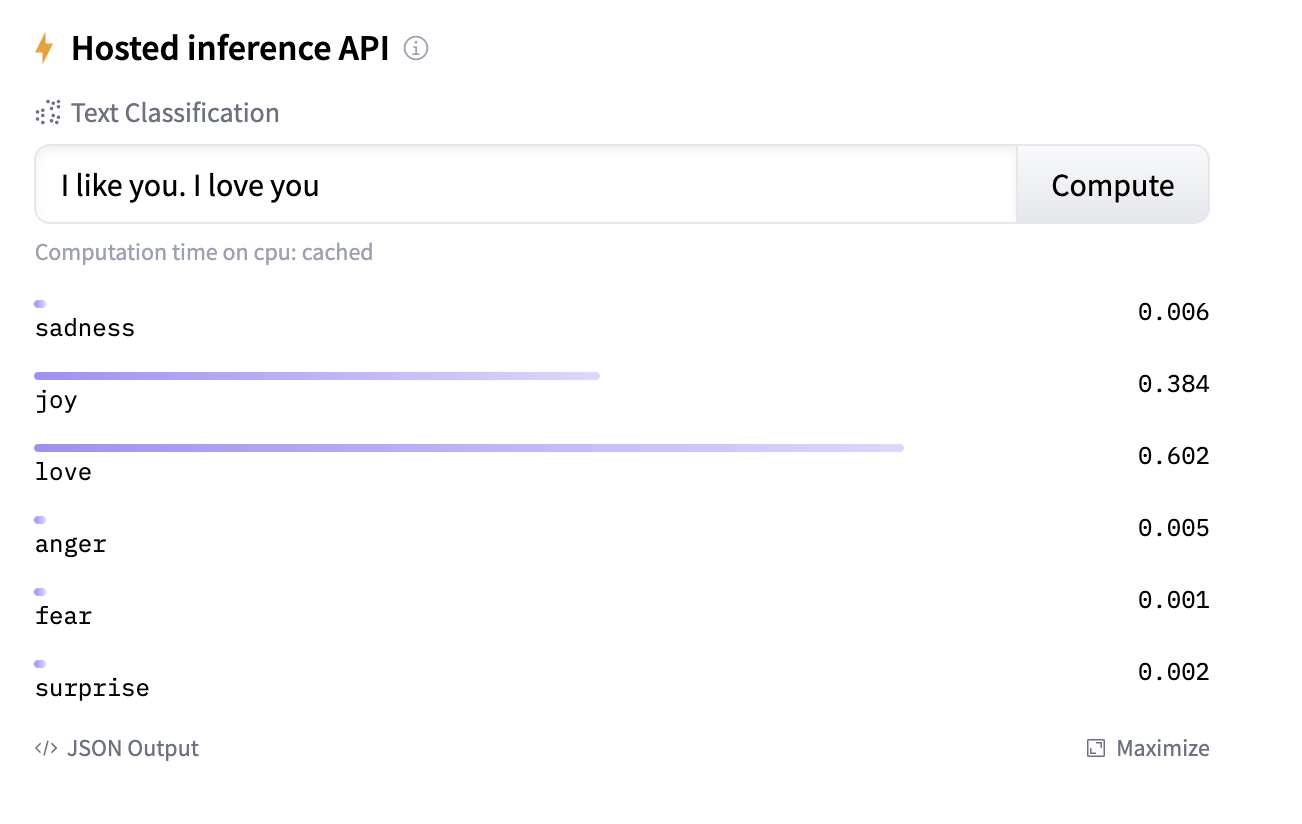

### Quick intro: Vision Transformer (ViT) by Google Brain
The Vision Transformer (ViT) is basically BERT, but applied to images. It attains excellent results compared to state-of-the-art convolutional networks. In order to provide images to the model, each image is split into a sequence of fixed-size patches (typically of resolution 16x16 or 32x32), which are linearly embedded. One also adds a [CLS] token at the beginning of the sequence in order to classify images. Next, one adds absolute position embeddings and provides this sequence to the Transformer encoder.

![vision-transformer-architecture](./imgs/vision-transformer-architecture.png)

* Paper: https://arxiv.org/abs/2010.11929
* Official repo (in JAX): https://github.com/google-research/vision_transformer

## Installation

In [1]:
#!pip install "tensorflow==2.6.0"
# !pip install transformers datasets --upgrade

## Setup & Configuration

In this step, we will define global configurations and parameters, which are used across the whole end-to-end fine-tuning process, e.g. `feature extractor` and `model` we will use. 

In this example are we going to fine-tune the [google/vit-base-patch16-224-in21k](https://huggingface.co/google/vit-base-patch16-224-in21k) a Vision Transformer (ViT) pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224.

In [2]:
model_id = "google/vit-base-patch16-224-in21k"

You can easily adjust the `model_id` to another Vision Transformer model, e.g. `google/vit-base-patch32-384`

## Dataset & Pre-processing

As Dataset we will use the [EuroSAT](https://paperswithcode.com/dataset/eurosat) an image classification dataset based on satellite images caputred by the Sentinel-2. The dataset consisting out of 10 classes (`Forest`, `River`, `Highway`, `AnnualCrop`,`SeaLake`, `HerbaceousVegetation`, `Industrial`, `Residential`, `PermanentCrop`, `Pasture`) with in total 27,000 labeled and geo-referenced images.


![eurosat-sample](./imgs/eurosat_overview_small.jpeg)  
Source: [EuroSAT](https://github.com/phelber/eurosat)

The `EuroSAT` is not yet available as a dataset in the `datasets` library. To be able to create a `Dataset` instance we need to write a small little helper function, which will load our `Dataset` from the filesystem and create the instance to use later for training. 

As a first step, we need to download the dataset to our filesystem and unzip it.

At the time of writing this example `datasets` does not yet support loading image dataset from the filesystem. Therefore we create a `create_image_folder_dataset` helper function to load the dataset from the filesystem. This method creates our `_CLASS_NAMES` and our `datasets.Features`. After that, it iterates through the filesystem and creates a `Dataset` instance.

In [3]:
from datasets import load_dataset

# ds = load_dataset('beans')
ds = load_dataset('imagefolder', data_dir="/home/miki/Documents/studia/praca_dyplomowa/breakhis/breakhis_400x")
ds

Resolving data files:   0%|          | 0/1820 [00:00<?, ?it/s]

Found cached dataset imagefolder (/home/miki/.cache/huggingface/datasets/imagefolder/default-e8800968233a46fb/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1820
    })
})

In [4]:
ex = ds['train'][400]
ex

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=700x460>,
 'label': 0}

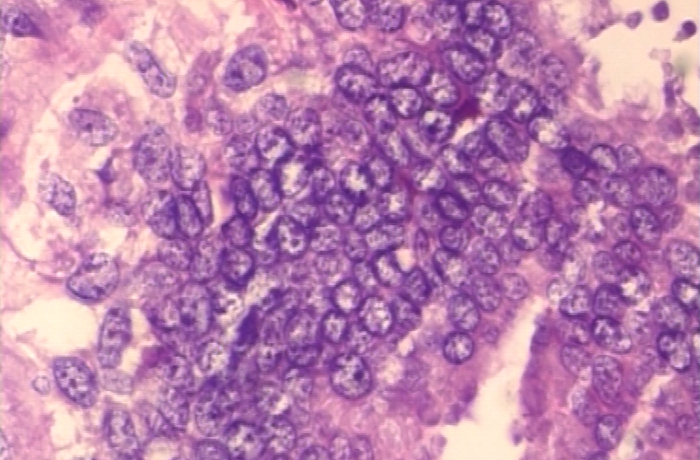

In [5]:
image = ex['image']
image

In [6]:

labels = ds['train'].features['label']
labels

ClassLabel(names=['benign', 'malignant'], id=None)

In [7]:
labels.int2str(ex['label'])

'benign'

In [8]:
labels.names

['benign', 'malignant']

2023-03-21 22:31:42.662128: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 22:31:44.100442: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64::/home/miki/anaconda3/lib/:/home/miki/anaconda3/envs/tf/lib/
2023-03-21 22:31:44.100612: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.7/lib64::/home/miki/ana

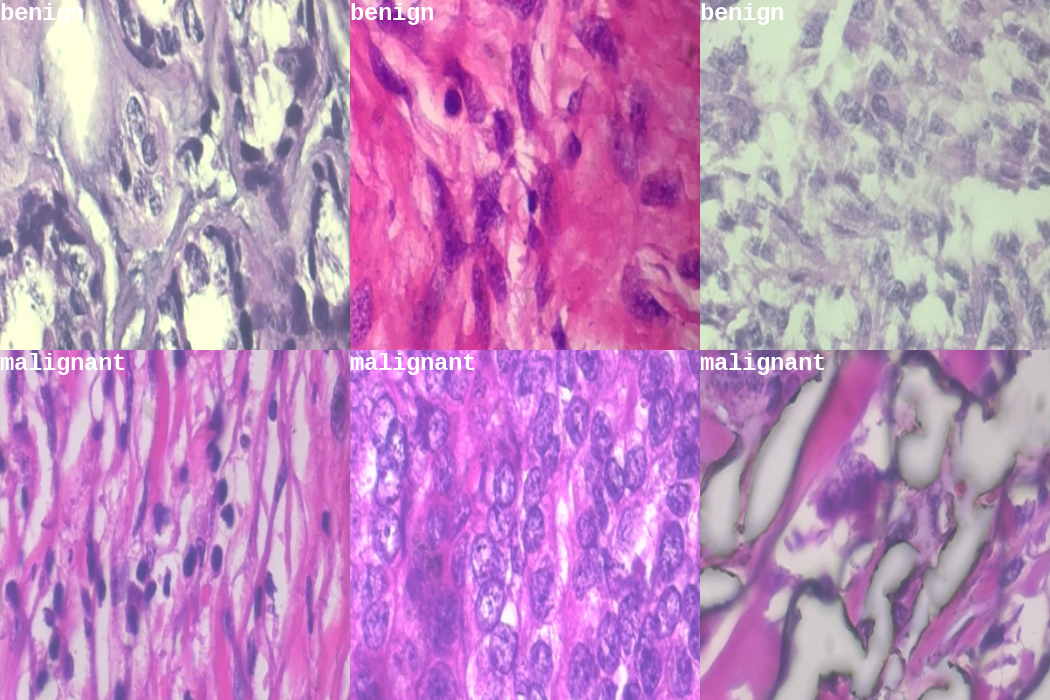

In [9]:
from transformers.utils.dummy_vision_objects import ImageGPTFeatureExtractor
import random
from PIL import ImageDraw, ImageFont, Image

def show_examples(ds, seed: int = 1234, examples_per_class: int = 3, size=(350, 350)):

    w, h = size
    labels = ds['train'].features['label'].names
    grid = Image.new('RGB', size=(examples_per_class * w, len(labels) * h))
    draw = ImageDraw.Draw(grid)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Bold.ttf", 24)

    for label_id, label in enumerate(labels):

        # Filter the dataset by a single label, shuffle it, and grab a few samples
        ds_slice = ds['train'].filter(lambda ex: ex['label'] == label_id).shuffle(seed).select(range(examples_per_class))

        # Plot this label's examples along a row
        for i, example in enumerate(ds_slice):
            image = example['image']
            idx = examples_per_class * label_id + i
            box = (idx % examples_per_class * w, idx // examples_per_class * h)
            grid.paste(image.resize(size), box=box)
            draw.text(box, label, (255, 255, 255), font=font)

    return grid

show_examples(ds, seed=random.randint(0, 1337), examples_per_class=3)

In [10]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/home/miki/anaconda3/envs/tf/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [11]:
feature_extractor

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [12]:
feature_extractor(image, return_tensors='tf')

2023-03-21 22:31:46.330364: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 22:31:46.351754: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 22:31:46.351932: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-21 22:31:46.352675: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

{'pixel_values': <tf.Tensor: shape=(1, 3, 224, 224), dtype=float32, numpy=
array([[[[ 0.69411767,  0.7019608 ,  0.8039216 , ...,  0.9764706 ,
           0.9843137 ,  0.92156863],
         [ 0.654902  ,  0.67058825,  0.7176471 , ...,  0.96862745,
           0.9764706 ,  0.9137255 ],
         [ 0.5921569 ,  0.67058825,  0.67058825, ...,  0.9607843 ,
           0.9607843 ,  0.9137255 ],
         ...,
         [ 0.69411767,  0.92156863,  0.827451  , ...,  0.54509807,
           0.5137255 ,  0.35686278],
         [ 0.85882354,  0.8509804 ,  0.7176471 , ...,  0.49803925,
           0.47450984,  0.32549024],
         [ 0.92156863,  0.7019608 ,  0.6       , ...,  0.45882356,
           0.47450984,  0.35686278]],

        [[ 0.27843142,  0.2313726 ,  0.30980396, ...,  0.7176471 ,
           0.7176471 ,  0.69411767],
         [ 0.24705887,  0.20784318,  0.24705887, ...,  0.7176471 ,
           0.70980394,  0.69411767],
         [ 0.19215691,  0.22352946,  0.22352946, ...,  0.7176471 ,
          

In [13]:
def process_example(example):
    inputs = feature_extractor(example['image'], return_tensors='tf')
    inputs['labels'] = example['label']
    return inputs

In [14]:
process_example(ds['train'][0])

{'pixel_values': <tf.Tensor: shape=(1, 3, 224, 224), dtype=float32, numpy=
array([[[[ 0.54509807,  0.56078434,  0.5529412 , ...,  0.54509807,
           0.5529412 ,  0.54509807],
         [ 0.5686275 ,  0.5764706 ,  0.5686275 , ...,  0.54509807,
           0.54509807,  0.5372549 ],
         [ 0.5764706 ,  0.58431375,  0.5686275 , ...,  0.54509807,
           0.54509807,  0.54509807],
         ...,
         [ 0.20000005,  0.23921573,  0.24705887, ...,  0.5686275 ,
           0.5764706 ,  0.5686275 ],
         [ 0.20784318,  0.24705887,  0.254902  , ...,  0.5764706 ,
           0.58431375,  0.58431375],
         [ 0.23921573,  0.27843142,  0.2941177 , ...,  0.5764706 ,
           0.5764706 ,  0.5764706 ]],

        [[ 0.33333337,  0.30196083,  0.33333337, ...,  0.6862745 ,
           0.6862745 ,  0.67058825],
         [ 0.3411765 ,  0.32549024,  0.34901965, ...,  0.6862745 ,
           0.6862745 ,  0.67058825],
         [ 0.34901965,  0.32549024,  0.33333337, ...,  0.69411767,
          

In [15]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs = feature_extractor([x for x in example_batch['image']], return_tensors='tf')

    # Don't forget to include the labels!
    inputs['labels'] = example_batch['label']
    return inputs

prepared_ds = ds.with_transform(transform)

In [16]:
prepared_ds['train'][0:2]

{'pixel_values': <tf.Tensor: shape=(2, 3, 224, 224), dtype=float32, numpy=
array([[[[ 0.54509807,  0.56078434,  0.5529412 , ...,  0.54509807,
           0.5529412 ,  0.54509807],
         [ 0.5686275 ,  0.5764706 ,  0.5686275 , ...,  0.54509807,
           0.54509807,  0.5372549 ],
         [ 0.5764706 ,  0.58431375,  0.5686275 , ...,  0.54509807,
           0.54509807,  0.54509807],
         ...,
         [ 0.20000005,  0.23921573,  0.24705887, ...,  0.5686275 ,
           0.5764706 ,  0.5686275 ],
         [ 0.20784318,  0.24705887,  0.254902  , ...,  0.5764706 ,
           0.58431375,  0.58431375],
         [ 0.23921573,  0.27843142,  0.2941177 , ...,  0.5764706 ,
           0.5764706 ,  0.5764706 ]],

        [[ 0.33333337,  0.30196083,  0.33333337, ...,  0.6862745 ,
           0.6862745 ,  0.67058825],
         [ 0.3411765 ,  0.32549024,  0.34901965, ...,  0.6862745 ,
           0.6862745 ,  0.67058825],
         [ 0.34901965,  0.32549024,  0.33333337, ...,  0.69411767,
          

### Pre-processing

To train our model we need to convert our "Images" to `pixel_values`. This is done by a [🤗 Transformers Feature Extractor](https://huggingface.co/docs/transformers/master/en/main_classes/feature_extractor#feature-extractor) which allows us to `augment` and convert the images into a 3D Array to be fed into our model.

In [17]:
# from transformers import ViTFeatureExtractor
# from tensorflow import keras 
# from tensorflow.keras import layers


# feature_extractor = ViTFeatureExtractor.from_pretrained(model_id)

# # learn more about data augmentation here: https://www.tensorflow.org/tutorials/images/data_augmentation
# data_augmentation = keras.Sequential(
#     [
#         layers.Resizing(feature_extractor.size, feature_extractor.size),
#         layers.Rescaling(1./255),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(factor=0.02),
#         layers.RandomZoom(
#             height_factor=0.2, width_factor=0.2
#         ),
#     ],
#     name="data_augmentation",
# )
# # use keras image data augementation processing
# def augmentation(examples):
#     # print(examples["img"])
#     examples["pixel_values"] = [data_augmentation(image) for image in examples["img"]]
#     return examples


# # basic processing (only resizing)
# def process(examples):
#     examples.update(feature_extractor(examples['img'], ))
#     return examples

# # we are also renaming our label col to labels to use `.to_tf_dataset` later
# # eurosat_ds = eurosat_ds.rename_column("label", "labels")



process our dataset using `.map` method with `batched=True`.

In [18]:
prepared_ds = ds.with_transform(transform)

# processed_dataset = eurosat_ds.map(process, batched=True)
# processed_dataset

# # augmenting dataset takes a lot of time
# processed_dataset = eurosat_ds.map(augmentation, batched=True)
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1820
    })
})

Since our dataset doesn't includes any split we need to `train_test_split` ourself to have an evaluation/test dataset for evaluating the result during and after training. 

In [19]:
# test size will be 15% of train dataset
test_size=.15

prepared_ds = prepared_ds["train"].shuffle().train_test_split(test_size=test_size)
prepared_ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1547
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 273
    })
})

## Fine-tuning the model using `Keras`

Now that our `dataset` is processed, we can download the pretrained model and fine-tune it. But before we can do this we need to convert our Hugging Face `datasets` Dataset into a `tf.data.Dataset`. For this, we will use the `.to_tf_dataset` method and a `data collator` (Data collators are objects that will form a batch by using a list of dataset elements as input).




## Hyperparameter

In [20]:
from huggingface_hub import HfFolder
import tensorflow as tf

id2label = {str(i): label for i, label in enumerate(labels.names)}
label2id = {v: k for k, v in id2label.items()}

num_train_epochs = 10
train_batch_size = 32
eval_batch_size = 32
learning_rate = 3e-5
weight_decay_rate=0.01
num_warmup_steps=0
output_dir=model_id.split("/")[1]
# hub_token = HfFolder.get_token() # or your token directly "hf_xxx"
# hub_model_id = f'{model_id.split("/")[1]}-beans'
fp16=True

# Train in mixed-precision float16
# Comment this line out if you're using a GPU that will not benefit from this
if fp16:
  tf.keras.mixed_precision.set_global_policy("mixed_float16")


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070 Laptop GPU, compute capability 8.6


2023-03-21 22:31:47.621385: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


### Converting the dataset to a `tf.data.Dataset`

In [21]:
from transformers import DefaultDataCollator

# Data collator that will dynamically pad the inputs received, as well as the labels.
data_collator = DefaultDataCollator(return_tensors="tf")

# converting our train dataset to tf.data.Dataset
tf_train_dataset = prepared_ds["train"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["label"],
   shuffle=True,
   batch_size=train_batch_size,
   collate_fn=data_collator)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = prepared_ds["test"].to_tf_dataset(
   columns=['pixel_values'],
   label_cols=["label"],
   shuffle=True,
   batch_size=eval_batch_size,
   collate_fn=data_collator)

### Download the pretrained transformer model and fine-tune it. 

In [22]:
from transformers import TFViTForImageClassification, create_optimizer
import tensorflow as tf

# create optimizer wight weigh decay
num_train_steps = len(tf_train_dataset) * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

# load pre-trained ViT model
model = TFViTForImageClassification.from_pretrained(
    model_id,
    num_labels=len(labels.names),
    id2label=id2label,
    label2id=label2id,
)

# define loss
loss=tf.keras.losses.BinaryCrossentropy(from_logits=False)

# define metrics 
metrics=[
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    # tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
]

# compile model
model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics
              )

labels.names

2023-03-21 22:31:50.455846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-21 22:31:51.138715: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-21 22:31:51.140140: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-21 22:31:51.140164: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-21 22:31:51.141118: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-21 22:31:51.141184: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
Some layers from the model 

['benign', 'malignant']

If you want to create you own classification head or if you want to add the augmentation/processing layer to your model, you can directly use the [functional Keras API](https://keras.io/guides/functional_api/). Below you find an example on how you would create a classification head.

In [23]:
# alternatively create Image Classification model using Keras Layer and ViTModel 
# here you can also add the processing layers of keras

# import tensorflow as tf
# from transformers import TFViTModel

# base_model = TFViTModel.from_pretrained('google/vit-base-patch16-224-in21k')


# # inputs
# pixel_values = tf.keras.layers.Input(shape=(3,224,224), name='pixel_values', dtype='float32')

# # model layer
# vit = base_model.vit(pixel_values)[0]
# classifier = tf.keras.layers.Dense(10, activation='softmax', name='outputs')(vit[:, 0, :])

# # model
# keras_model = tf.keras.Model(inputs=pixel_values, outputs=classifier)

### Callbacks

As mentioned in the beginning we want to use the [Hugging Face Hub](https://huggingface.co/models) for model versioning and monitoring. Therefore we want to push our model weights, during training and after training to the Hub to version it.
Additionally, we want to track the performance during training therefore we will push the `Tensorboard` logs along with the weights to the Hub to use the "Training Metrics" Feature to monitor our training in real-time. 



In [24]:
import os
from transformers.keras_callbacks import PushToHubCallback
from tensorflow.keras.callbacks import TensorBoard as TensorboardCallback, EarlyStopping

callbacks=[]

# callbacks.append(TensorboardCallback(log_dir=os.path.join(output_dir,"logs")))
# callbacks.append(EarlyStopping(monitor="val_accuracy",patience=1))
# if hub_token:
  # callbacks.append(PushToHubCallback(output_dir=output_dir,
                                    #  hub_model_id=hub_model_id,
                                    #  hub_token=hub_token))



![tensorboard](./imgs/tensorboard.png)

## Training

Start training with calling `model.fit`

In [25]:
train_results = model.fit(
    tf_train_dataset,
    validation_data=tf_eval_dataset,
    callbacks=callbacks,
    epochs=num_train_epochs,
)

Epoch 1/10
49/49 [==============================] - 53s 781ms/step - loss: 0.9265 - accuracy: 0.6183 - val_loss: 0.3463 - val_accuracy: 0.8645
Epoch 2/10
49/49 [==============================] - 37s 742ms/step - loss: 0.2734 - accuracy: 0.8930 - val_loss: 0.2369 - val_accuracy: 0.9286
Epoch 3/10
49/49 [==============================] - 37s 742ms/step - loss: 0.1385 - accuracy: 0.9463 - val_loss: 0.1608 - val_accuracy: 0.9469
Epoch 4/10
49/49 [==============================] - 37s 747ms/step - loss: 0.1291 - accuracy: 0.9670 - val_loss: 0.1485 - val_accuracy: 0.9634
Epoch 5/10
49/49 [==============================] - 37s 745ms/step - loss: 0.0999 - accuracy: 0.9690 - val_loss: 0.1120 - val_accuracy: 0.9707
Epoch 6/10
49/49 [==============================] - 37s 746ms/step - loss: 0.0278 - accuracy: 0.9935 - val_loss: 0.1347 - val_accuracy: 0.9799
Epoch 7/10
49/49 [==============================] - 37s 750ms/step - loss: 0.0103 - accuracy: 0.9990 - val_loss: 0.1378 - val_accuracy: 0.9799